In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import optuna
import os

from functions import *
from RDF import *

/data/antares/users/jwbosman/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# orca 10 Data

Now as the total of data for the atmospheric neutrinos has 14597 entries, we select 14597 entries from the muon dataset as wel. This is to create a more balanced training dataset.

Note that is_cc = 2.0 means it is CC and is_cc = 3.0 means not cc (in the original file.)


## loading and preselecting data

In [2]:
plt.rcParams["figure.figsize"] = (7,7)
plt.rcParams["figure.labelsize"] = 14
plt.rcParams["figure.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12

In [3]:
data = pd.read_hdf("/data/antares/users/jwbosman/ORCA10/post_general_selection_cuts_data.h5")

In [15]:
start = 0.0
stop = 0.03
n = 50
muons = data[data["is_neutrino"] == 0]
neutrinos = data[data["is_neutrino"] == 1]
old_contamination, old_efficiency, score_thresholds = contamination_vs_desired_efficiency(muons, neutrinos, new_scores = False, start = start, stop = stop, n= n )

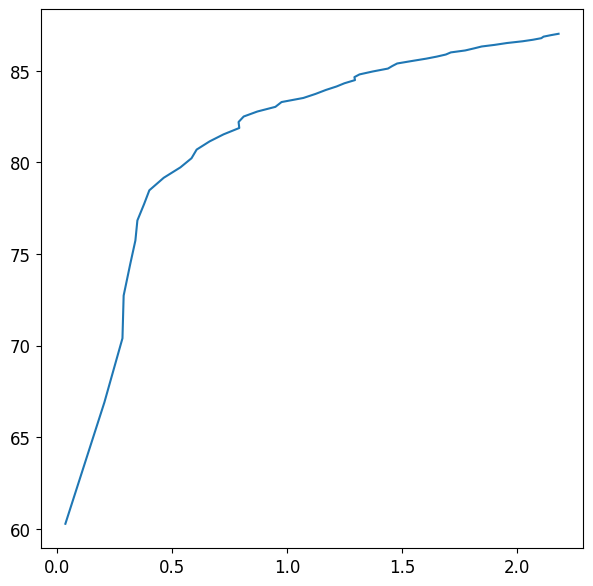

In [16]:
plt.plot(old_contamination, old_efficiency, label = "old")



In [9]:
for column in data.columns:
    print(column)

E.frame_index
mc_id
energy
E.mc_trks.dir.z[:,0]
pos_x
pos_y
pos_z
run_id
E.trigger_counter
trigger_mask
energy_recoJEnergy
energy_recoJShower
E.trks.dir.x[:,0]
E.trks.dir.x[:,1]
E.trks.dir.y[:,0]
E.trks.dir.y[:,1]
E.trks.dir.z[:,0]
E.trks.dir.z[:,1]
beta0
track_length_JGandalf
E.trks.fitinf[:,0,13]
E.trks.fitinf[:,0,14]
E.trks.fitinf[:,0,15]
E.trks.fitinf[:,0,16]
E.trks.fitinf[:,0,1]
E.trks.fitinf[:,0,2]
E.trks.fitinf[:,0,3]
E.trks.fitinf[:,0,5]
E.trks.fitinf[:,0,6]
E.trks.fitinf[:,0,7]
E.trks.fitinf[:,0,9]
likelihood_JGandalf
E.trks.lik[:,1]
pos_x_recoJGandalf
pos_x_recoJShower
pos_y_recoJGandalf
pos_y_recoJShower
pos_z_recoJGandalf
pos_z_recoJShower
rectype_JShower
E.trks.t[:,0]
E.trks.t[:,1]
T.feat_Neutrino2020.QupMinusQdn
T.feat_Neutrino2020.QupOvernHits
T.feat_Neutrino2020.cherCond_hits_meanZposition
T.feat_Neutrino2020.cherCond_hits_trig_meanZposition
T.feat_Neutrino2020.cherCond_n_doms
T.feat_Neutrino2020.cherCond_n_doms_trig
T.feat_Neutrino2020.cherCond_n_hits_dnMup
T.feat_Neut

In [12]:
simulation_columns = ['mc_id', 'E.mc_trks.dir.z[:,0]', 'run_id', 'rectype_JShower', 'T.sum_mc_evt.E_max_gen',
                           'T.sum_mc_evt.E_min_gen', 'T.sum_mc_evt.livetime_DAQ', 'T.sum_mc_evt.weight', 'T.sum_mc_evt.weight_noOsc', 
                           'weight', 'exposure', 'weight_rate', 'type', 'run_duration', 'is_cc', 'is_neutrino', 'cos_zenith_true', 
                           'bjorken_y_true', 'w1', 'w2', 'ngen', 'E_min_gen', 'weight_one_year', 'pdgid', 'muonscore', 'runs_neutrino2024_veto_sparks', 'E.frame_index', "E.trigger_counter", "EG", "E.mc_trks.dir.z[:,0]", 
                            "isJsirene", "sel_HP_track", "sel_LP_track", "sel_shower",
                            "run_duration", "pos_x", "pos_y", "pos_z", "energy", "int_len"]
    
y_full = data[simulation_columns]
X_full = data.drop(columns = simulation_columns)

top_50_relevant_columns_basemodel = ['E.trks.dir.z[:,1]', 'cos_zenith_recoJShower',
       'T.feat_Neutrino2020.cherCond_n_hits_dnMup',
       'T.feat_Neutrino2020.cherCond_n_hits_trig_dnMup',
       'T.feat_Neutrino2020.cherCond_hits_meanZposition',
       'T.feat_Neutrino2020.cherCond_hits_trig_meanZposition',
       'angle_shfit_gandalf', 'T.feat_Neutrino2020.cherCond_n_hits_trig_dnf',
       'meanZhitTrig', 'T.feat_Neutrino2020.cherCond_n_hits_dnf',
       'T.feat_Neutrino2020.cherCond_n_hits_upf', 'pos_r_JGandalf',
       'E.trks.fitinf[:,0,2]', 'likelihood_JGandalf',
       'T.feat_Neutrino2020.QupOvernHits',
       'T.feat_Neutrino2020.zClosestApproach', 'pos_z_recoJShower',
       'T.sum_jppshower.prefit_posfit_distance', 'pos_z_recoJGandalf',
       'ratio_E_jshf_gandalf', 'maximumToT_triggerHit',
       'gandalf_shfit_lik_ratio', 'loglik_jg',
       'T.feat_Neutrino2020.gandalf_Qup',
       'T.feat_Neutrino2020.n_hits_earlyTrig',
       'T.feat_Neutrino2020.cherCond_n_hits_trig_upf',
       'T.feat_Neutrino2020.QupMinusQdn', 'closest[:,1,1]',
       'T.sum_hits.nlines', 'T.sum_jppshower.prefit_posfit_dt',
       'closest[:,0,0]', 'sumtot[:,1,1]',
       'T.feat_Neutrino2020.cherCond_n_doms',
       'T.feat_Neutrino2020.dClosestApproach', 'min_dom_dist',
       'energy_recoJEnergy', 'E.trks.dir.y[:,1]', 'E.trks.fitinf[:,0,13]',
       'crkv_nhits50[:,1,1]', 'T.sum_trig_hits.atot', 'T.sum_hits.nhits',
       'trackscore', 'closest[:,1,0]', 'crkv_nhits[:,1,0]', 'furthest[:,1,1]',
       'E.trks.dir.z[:,0]', 'T.sum_hits.ndoms', 'crkv_nhits[:,1,1]',
       'cos_zenith_recoJGandalf', 'energy_recoJShower']

X_full = X_full[top_50_relevant_columns_basemodel]
print("training columns are:")
for column in X_full.columns:
    print(column)

print("shape of X_full is", X_full.shape)
print("shape of y_full is", y_full.shape)


training columns are:
E.trks.dir.z[:,1]
cos_zenith_recoJShower
T.feat_Neutrino2020.cherCond_n_hits_dnMup
T.feat_Neutrino2020.cherCond_n_hits_trig_dnMup
T.feat_Neutrino2020.cherCond_hits_meanZposition
T.feat_Neutrino2020.cherCond_hits_trig_meanZposition
angle_shfit_gandalf
T.feat_Neutrino2020.cherCond_n_hits_trig_dnf
meanZhitTrig
T.feat_Neutrino2020.cherCond_n_hits_dnf
T.feat_Neutrino2020.cherCond_n_hits_upf
pos_r_JGandalf
E.trks.fitinf[:,0,2]
likelihood_JGandalf
T.feat_Neutrino2020.QupOvernHits
T.feat_Neutrino2020.zClosestApproach
pos_z_recoJShower
T.sum_jppshower.prefit_posfit_distance
pos_z_recoJGandalf
ratio_E_jshf_gandalf
maximumToT_triggerHit
gandalf_shfit_lik_ratio
loglik_jg
T.feat_Neutrino2020.gandalf_Qup
T.feat_Neutrino2020.n_hits_earlyTrig
T.feat_Neutrino2020.cherCond_n_hits_trig_upf
T.feat_Neutrino2020.QupMinusQdn
closest[:,1,1]
T.sum_hits.nlines
T.sum_jppshower.prefit_posfit_dt
closest[:,0,0]
sumtot[:,1,1]
T.feat_Neutrino2020.cherCond_n_doms
T.feat_Neutrino2020.dClosestAppro

In [13]:
SKF = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

for train_index, test_index in SKF.split(X_full, y_full["is_neutrino"]):
    X_train, X_test = X_full.iloc[train_index], X_full.iloc[test_index]
    y_train, y_test = y_full.iloc[train_index], y_full.iloc[test_index]

    print("training X data has shape", X_train.shape)
    print("training y data has shape", y_train.shape)
    print("testing X data has shape", X_test.shape)
    print("testing y data has shape", y_test.shape)

    continue

training X data has shape (558779, 50)
training y data has shape (558779, 40)
testing X data has shape (139695, 50)
testing y data has shape (139695, 40)
training X data has shape (558779, 50)
training y data has shape (558779, 40)
testing X data has shape (139695, 50)
testing y data has shape (139695, 40)
training X data has shape (558779, 50)
training y data has shape (558779, 40)
testing X data has shape (139695, 50)
testing y data has shape (139695, 40)
training X data has shape (558779, 50)
training y data has shape (558779, 40)
testing X data has shape (139695, 50)
testing y data has shape (139695, 40)
training X data has shape (558780, 50)
training y data has shape (558780, 40)
testing X data has shape (139694, 50)
testing y data has shape (139694, 40)


## first test rdf, to see feature importance and get baseline

In [76]:
random_state = 42

kfold = KFold(n_splits=5, shuffle=True, random_state=random_state)
exp_data = pd.DataFrame()
importances = np.zeros(len(X_full.columns))

for train_index, test_index in kfold.split(X_full):

    X_train, X_test = X_full.iloc[train_index].copy(), X_full.iloc[test_index].copy()
    y_train_compl, y_test_compl = y_full.iloc[train_index].copy(), y_full.iloc[test_index].copy()

    y_train = y_train_compl['is_neutrino']

    clf = RFC(random_state=random_state, verbose = 0)       
    clf.fit(X_train, y_train)
    importances += clf.feature_importances_
    prediction_probabilities = clf.predict_proba(X_test)
    y_pred = np.argmax(prediction_probabilities, axis = 1)

    y_test_compl['muonscore_new'] = prediction_probabilities[:,0]
    y_test_compl['prediction'] = y_pred
    y_test_compl["energy_recoJEnergy"] = X_test["energy_recoJEnergy"]
    y_test_compl["energy_recoJShower"] = X_test["energy_recoJShower"]
    # y_test_compl[""] = X_test['jmuon_E']

    exp_data = pd.concat([exp_data, y_test_compl])

importances = importances/5


In [77]:
import NIKHEF_repo.RDF_optuna as RDF_optuna
import importlib
importlib.reload(RDF_optuna)
from NIKHEF_repo.RDF_optuna import score_histogram, plot_feature_importances


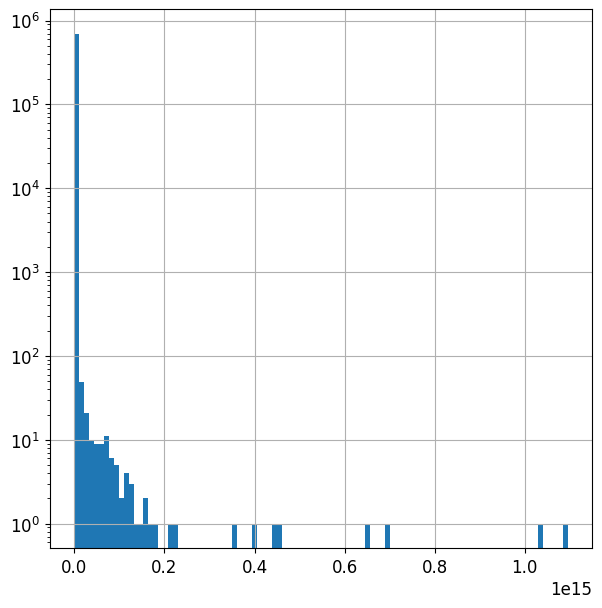

In [36]:
hist = data["int_len"].hist(bins=100, log = True)

In [81]:
score_histogram(exp_data, "ORCA10", False)
score_histogram(exp_data, "ORCA10", True)
plot_feature_importances(importances, X_full.columns, "ORCA10", save_dir="/data/antares/users/jwbosman/results/ORCA10/post_cuts/")



Feature ranking:
1. feature cos_zenith_recoJShower (0.151773)
2. feature E.trks.dir.z[:,1] (0.106373)
3. feature T.feat_Neutrino2020.cherCond_n_hits_dnMup (0.084964)
4. feature T.feat_Neutrino2020.cherCond_n_hits_trig_dnMup (0.066295)
5. feature angle_shfit_gandalf (0.062616)
6. feature T.feat_Neutrino2020.cherCond_n_hits_trig_dnf (0.038118)
7. feature T.feat_Neutrino2020.cherCond_hits_trig_meanZposition (0.031973)
8. feature T.feat_Neutrino2020.cherCond_hits_meanZposition (0.029972)
9. feature meanZhitTrig (0.024618)
10. feature T.feat_Neutrino2020.cherCond_n_hits_dnf (0.019524)
11. feature pos_r_JGandalf (0.018811)
12. feature T.feat_Neutrino2020.zClosestApproach (0.017396)
13. feature T.sum_jppshower.prefit_posfit_distance (0.016840)
14. feature maximumToT_triggerHit (0.016516)
15. feature T.feat_Neutrino2020.QupOvernHits (0.015831)
16. feature T.sum_hits.nlines (0.014389)
17. feature pos_z_recoJShower (0.013367)
18. feature loglik_jg (0.012573)
19. feature gandalf_shfit_lik_ratio (

In [74]:
indices = np.argsort(importances)[::-1]
sorted_column_names = X_full.columns[indices[:50]]
print(sorted_column_names)

Index(['E.trks.dir.z[:,1]', 'cos_zenith_recoJShower',
       'T.feat_Neutrino2020.cherCond_n_hits_dnMup',
       'T.feat_Neutrino2020.cherCond_n_hits_trig_dnMup',
       'T.feat_Neutrino2020.cherCond_hits_meanZposition',
       'T.feat_Neutrino2020.cherCond_hits_trig_meanZposition',
       'angle_shfit_gandalf', 'T.feat_Neutrino2020.cherCond_n_hits_trig_dnf',
       'meanZhitTrig', 'T.feat_Neutrino2020.cherCond_n_hits_dnf',
       'T.feat_Neutrino2020.cherCond_n_hits_upf', 'pos_r_JGandalf',
       'E.trks.fitinf[:,0,2]', 'likelihood_JGandalf',
       'T.feat_Neutrino2020.QupOvernHits',
       'T.feat_Neutrino2020.zClosestApproach', 'pos_z_recoJShower',
       'T.sum_jppshower.prefit_posfit_distance', 'pos_z_recoJGandalf',
       'ratio_E_jshf_gandalf', 'maximumToT_triggerHit',
       'gandalf_shfit_lik_ratio', 'loglik_jg',
       'T.feat_Neutrino2020.gandalf_Qup',
       'T.feat_Neutrino2020.n_hits_earlyTrig',
       'T.feat_Neutrino2020.cherCond_n_hits_trig_upf',
       'T.feat_Neutri

## determine neutrino efficiency

In [82]:
from NIKHEF_repo.RDF_optuna import plot_efficiency_contamination
from NIKHEF_repo.RDF_optuna import contamination_vs_desired_efficiency

In [83]:
muons = exp_data[exp_data['is_neutrino'] == 0]
neutrinos = exp_data[exp_data['is_neutrino'] == 1]


In [84]:
old_contamination, old_efficiency, score_thresholds = contamination_vs_desired_efficiency(muons, neutrinos, False, start = 0 , stop = 0.5e-1, n = 100)
new_contamination, new_efficiency, score_thresholds = contamination_vs_desired_efficiency(muons, neutrinos, True, start = 0 , stop = 0.5e-1, n = 100)



/data/antares/users/jwbosman/NIKHEF_repo/RDF.py:55: RuntimeWarning: invalid value encountered in scalar divide
  contamination_perc = rem_muons/(rem_muons+rem_neutrs)*100


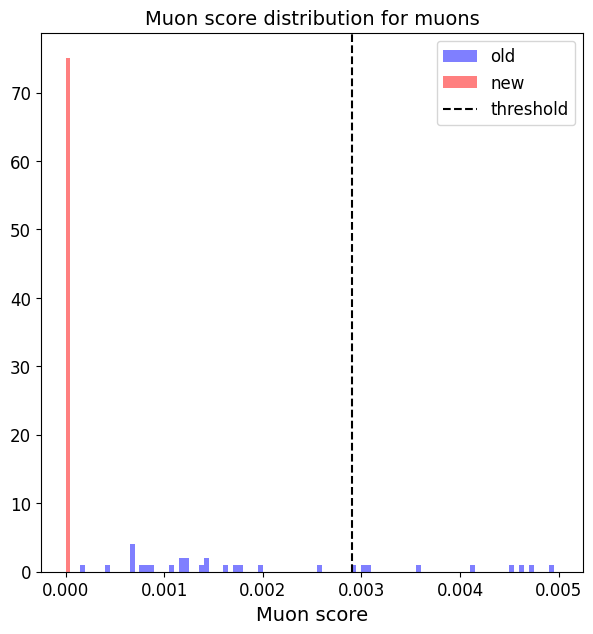

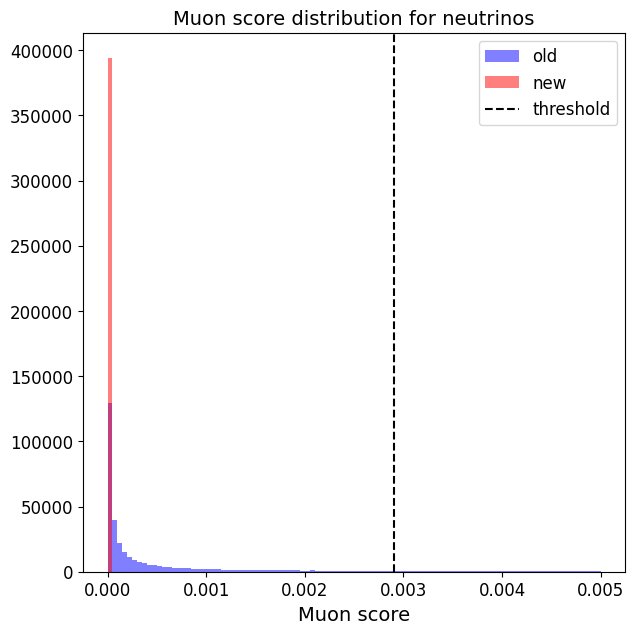

In [101]:
weights_muons = muons["weight_one_year"].values
weights_neutrinos = neutrinos["weight_one_year"].values
weights_muons = np.ones(len(muons))
weights_neutrinos = np.ones(len(neutrinos))
plt.hist(muons["muonscore"].to_numpy(), bins=100, weights = weights_muons, log = False, density = False, alpha = 0.5, color = "blue", range = (0, 0.5e-2), label = "old")
plt.hist(muons["muonscore_new"].to_numpy(), bins=100, weights = weights_muons, log = False, density = False, alpha = 0.5, color = "red", range = (0, 0.5e-2), label = "new")

plt.axvline(x = 2.9e-3, color = "black", linestyle = "dashed", label = "threshold")
plt.title("Muon score distribution for muons")
plt.xlabel("Muon score")
plt.legend()
plt.show()

plt.hist(neutrinos["muonscore"].to_numpy(), bins=100, weights = weights_neutrinos, log = False, density = False, alpha = 0.5, color = "blue", range = (0, 0.5e-2), label = "old")
plt.hist(neutrinos["muonscore_new"].to_numpy(), bins=100, weights = weights_neutrinos, log = False, density = False, alpha = 0.5, color = "red", range = (0, 0.5e-2), label = "new")
plt.axvline(x = 2.9e-3, color = "black", linestyle = "dashed", label = "threshold")
plt.title("Muon score distribution for neutrinos")
plt.xlabel("Muon score")
plt.legend()
plt.show()

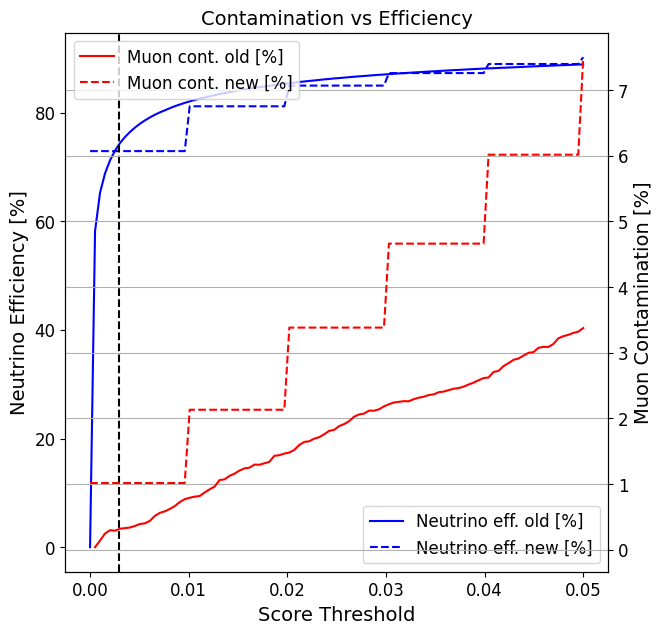

In [86]:
plot_efficiency_contamination(score_thresholds, old_contamination, new_contamination, old_efficiency, new_efficiency, save_dir="/data/antares/users/jwbosman/results/ORCA10/post_cuts/")

## new figure of merit
Follow true oscillation analysis cutoffs for muon_score, track_score etc. to create the final data for which to determine the desired neutrino efficiency. https://wiki.km3net.de/index.php/Neutrino_Oscillations/Oscillation_Analysis_ORCA6/10/11 .


In [27]:
total_E_mask_neutrinos = neutrinos['energy'] <= 20
total_E_mask_muons = muons["energy"] <= 20

low_E_mask_neutrinos = neutrinos['energy'] <= 10
low_E_mask_muons = muons["energy"] <= 10

high_E_mask_neutrinos = (neutrinos['energy'] <= 20) & (neutrinos['energy'] > 10)
high_E_mask_muons = (muons["energy"] <= 20) & (muons["energy"] > 10)

low_E_reco_mask_muons = (muons['E.trks.E[.,0]'] <= 10) | (muons['E.trks.E[.,1]'] <= 10)
low_E_reco_mask_neutrinos = (neutrinos['E.trks.E[.,0]'] <= 10) | (neutrinos['E.trks.E[.,1]'] <= 10)

high_E_reco_mask_neutrinos = ((neutrinos['E.trks.E[.,0]'] <= 20) & (neutrinos['E.trks.E[.,0]'] > 10)) | ((neutrinos['E.trks.E[.,1]'] <= 20) & (neutrinos['E.trks.E[.,1]'] > 10))
high_E_reco_mask_muons = ((muons['E.trks.E[.,0]'] <= 20) & (muons['E.trks.E[.,0]'] > 10)) | ((muons['E.trks.E[.,1]'] <= 20) & (muons['E.trks.E[.,1]'] > 10))

print("amount of neutrino points both in low and high reco brackets = {}".format(np.sum(low_E_reco_mask_neutrinos & high_E_reco_mask_neutrinos)))

print("amount of neutrino data points in low reco bracket = {}".format(np.sum(low_E_reco_mask_neutrinos)))
print("amount of neutrino data points in high reco bracket = {}".format(np.sum(high_E_reco_mask_neutrinos)))

print("amount of desired neutrino data points in low reco bracket = {}".format(np.sum(low_E_reco_mask_neutrinos & total_E_mask_neutrinos)))
print("amount of desired neutrino data points in high reco bracket = {}".format(np.sum(high_E_reco_mask_neutrinos & total_E_mask_neutrinos)))
print("total amount of desired neutrino datapoints = {}".format(np.sum(total_E_mask_neutrinos)))

n_desired_neutrinos_low_reco = np.sum(neutrinos[low_E_reco_mask_neutrinos & total_E_mask_neutrinos]["flux_weight"])
n_desired_neutrinos_high_reco = np.sum(neutrinos[high_E_reco_mask_neutrinos & total_E_mask_neutrinos]["flux_weight"])
n_desired_neutrinos_total = np.sum(neutrinos[total_E_mask_neutrinos]["flux_weight"])
print("n desired neutrinos low reco: ", n_desired_neutrinos_low_reco)
print("n desired neutrinos high reco: ", n_desired_neutrinos_high_reco)
print("n desired neutrinos total: ", n_desired_neutrinos_total)

amount of neutrino points both in low and high reco brackets = 84632
amount of neutrino data points in low reco bracket = 266063
amount of neutrino data points in high reco bracket = 123791
amount of desired neutrino data points in low reco bracket = 182233
amount of desired neutrino data points in high reco bracket = 66698
total amount of desired neutrino datapoints = 190917
n desired neutrinos low reco:  3691.891716421827
n desired neutrinos high reco:  754.0883077112785
n desired neutrinos total:  3711.688832499777


Need to really make this plot more straightforward and adaptable.

Amount of muons in low reco bracket is:  73314.14810678014
Amount of neutrinos in low reco bracket is:  3700.227583836464
Amount of muons in high reco bracket is:  79283.59993261239
Amount of neutrinos in high reco bracket is:  760.451961932571


/tmp/ipykernel_107817/3839714258.py:84: RuntimeWarning: invalid value encountered in scalar divide
  muon_contamination_percentages_low.append(n_remaining_muons_low_reco/(n_remaining_muons_low_reco + n_remaining_neutrinos_low_reco)*100)
/tmp/ipykernel_107817/3839714258.py:85: RuntimeWarning: invalid value encountered in scalar divide
  muon_contamination_percentages_high.append(n_remaining_muons_high_reco/(n_remaining_muons_high_reco + n_remaining_neutrinos_high_reco)*100)
/tmp/ipykernel_107817/3839714258.py:86: RuntimeWarning: invalid value encountered in scalar divide
  muon_contamination_percentages_total.append(n_remaining_muons_total/(n_remaining_muons_total + n_remaining_neutrinos_total)*100)
/tmp/ipykernel_107817/3839714258.py:88: RuntimeWarning: invalid value encountered in scalar divide
  contamination_percentages_low.append((n_remaining_muons_low_reco+n_remaining_neutrinos_low_reco - n_remaining_desired_neutrinos_low_reco)/(n_remaining_muons_low_reco + n_remaining_neutrinos_l

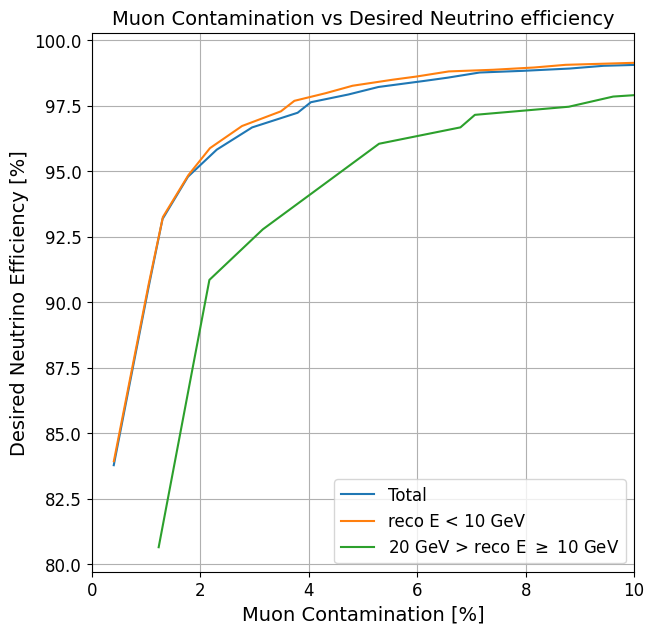

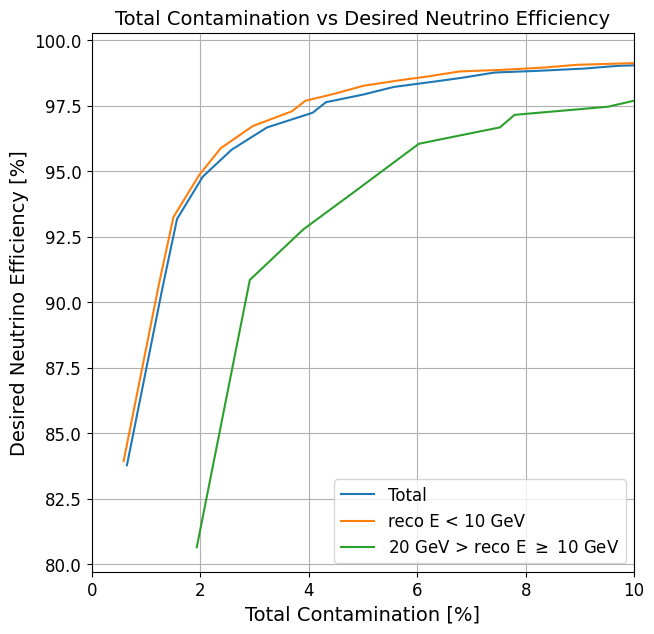

In [30]:
"""
Needs to quantify the amount of usefull/desired neutrinos that are available after the entire process.
Will need to be weighted according to the flux of neutrinos at the different energies/ for different neutrinos.
Roughest estimate would be to take the neutrino efficiency but take out the neutrinos that have a true energy higher than 20 GeV.
Could also filter out neutrinos that are not truly upgoing.
Should try these things out first.

But now how to visualize this?
Simplest is just a number.

Should i constrain on true energy and dir or reconstructed?

"""

make_plot = True
desired_neutrinos_efficiency_low = []
desired_neutrinos_efficiency_high = []
desired_neutrinos_efficiency_total = []

muon_contamination_percentages_low = []
muon_contamination_percentages_high = []
muon_contamination_percentages_total = []

contamination_percentages_low = []
contamination_percentages_high = []
contamination_percentages_total = []

total_E_mask_neutrinos = neutrinos['energy'] <= 20
total_E_mask_muons = muons["energy"] <= 20

low_E_mask_neutrinos = neutrinos['energy'] <= 10
low_E_mask_muons = muons["energy"] <= 10

high_E_mask_neutrinos = (neutrinos['energy'] <= 20) & (neutrinos['energy'] > 10)
high_E_mask_muons = (muons["energy"] <= 20) & (muons["energy"] > 10)

low_E_reco_mask_muons = (muons['E.trks.E[.,0]'] <= 10) | (muons['E.trks.E[.,1]'] <= 10)
low_E_reco_mask_neutrinos = (neutrinos['E.trks.E[.,0]'] <= 10) | (neutrinos['E.trks.E[.,1]'] <= 10)
print("Amount of muons in low reco bracket is: ", np.sum(muons[low_E_reco_mask_muons]["weight_one_year"]))
print("Amount of neutrinos in low reco bracket is: ", np.sum(neutrinos[low_E_reco_mask_neutrinos]["flux_weight"]))

high_E_reco_mask_neutrinos = ((neutrinos['E.trks.E[.,0]'] <= 20) & (neutrinos['E.trks.E[.,0]'] > 10)) | ((neutrinos['E.trks.E[.,1]'] <= 20) & (neutrinos['E.trks.E[.,1]'] > 10))
high_E_reco_mask_muons = ((muons['E.trks.E[.,0]'] <= 20) & (muons['E.trks.E[.,0]'] > 10)) | ((muons['E.trks.E[.,1]'] <= 20) & (muons['E.trks.E[.,1]'] > 10))
print("Amount of muons in high reco bracket is: ", np.sum(muons[high_E_reco_mask_muons]["weight_one_year"]))
print("Amount of neutrinos in high reco bracket is: ", np.sum(neutrinos[high_E_reco_mask_neutrinos]["flux_weight"]))

n_desired_neutrinos_low_reco = np.sum(neutrinos[low_E_reco_mask_neutrinos & total_E_mask_neutrinos]["flux_weight"])
n_desired_neutrinos_high_reco = np.sum(neutrinos[high_E_reco_mask_neutrinos & total_E_mask_neutrinos]["flux_weight"])

n_desired_neutrinos_low_true = np.sum(neutrinos[low_E_mask_neutrinos]["weight_one_year"])
n_desired_neutrinos_high_true = np.sum(neutrinos[high_E_mask_neutrinos]["weight_one_year"])


n_desired_neutrinos_total = np.sum(neutrinos[total_E_mask_neutrinos]["flux_weight"])


if make_plot:
    for muon_score_threshold in np.linspace(0,0.2,100):

        neutrino_score_mask = neutrinos['muon_score'] < muon_score_threshold
        muon_score_mask = muons['muon_score'] < muon_score_threshold

        n_remaining_muons_low_reco = np.sum(muons[muon_score_mask & low_E_reco_mask_muons]["weight_one_year"])
        n_remaining_muons_high_reco = np.sum(muons[muon_score_mask & high_E_reco_mask_muons]["weight_one_year"])
        n_remaining_muons_total = np.sum(muons[muon_score_mask]["weight_one_year"])

        n_remaining_neutrinos_low_reco = np.sum(neutrinos[neutrino_score_mask & low_E_reco_mask_neutrinos]["flux_weight"])
        n_remaining_neutrinos_high_reco = np.sum(neutrinos[neutrino_score_mask & high_E_reco_mask_neutrinos]["flux_weight"])
        n_remaining_neutrinos_total = np.sum(neutrinos[neutrino_score_mask]["flux_weight"])

        n_remaining_desired_neutrinos_low_reco = np.sum(neutrinos[neutrino_score_mask & low_E_reco_mask_neutrinos & total_E_mask_neutrinos]["flux_weight"])
        n_remaining_desired_neutrinos_high_reco = np.sum(neutrinos[neutrino_score_mask & high_E_reco_mask_neutrinos & total_E_mask_neutrinos]["flux_weight"])
        n_remaining_desired_neutrinos_total = np.sum(neutrinos[neutrino_score_mask & total_E_mask_neutrinos]["flux_weight"])



        # print("n remaining neutrinos: ", n_remaining_neutrinos)
        # print("n remaining desired neutrinos: ", n_remaining_desired_neutrinos)
        
        desired_neutrinos_efficiency_low.append(n_remaining_desired_neutrinos_low_reco/n_desired_neutrinos_low_reco*100)
        desired_neutrinos_efficiency_high.append(n_remaining_desired_neutrinos_high_reco/n_desired_neutrinos_high_reco*100)
        desired_neutrinos_efficiency_total.append(n_remaining_desired_neutrinos_total/n_desired_neutrinos_total*100)

        muon_contamination_percentages_low.append(n_remaining_muons_low_reco/(n_remaining_muons_low_reco + n_remaining_neutrinos_low_reco)*100)
        muon_contamination_percentages_high.append(n_remaining_muons_high_reco/(n_remaining_muons_high_reco + n_remaining_neutrinos_high_reco)*100)
        muon_contamination_percentages_total.append(n_remaining_muons_total/(n_remaining_muons_total + n_remaining_neutrinos_total)*100)

        contamination_percentages_low.append((n_remaining_muons_low_reco+n_remaining_neutrinos_low_reco - n_remaining_desired_neutrinos_low_reco)/(n_remaining_muons_low_reco + n_remaining_neutrinos_low_reco)*100)
        contamination_percentages_high.append((n_remaining_muons_high_reco+n_remaining_neutrinos_high_reco - n_remaining_desired_neutrinos_high_reco)/(n_remaining_muons_high_reco + n_remaining_neutrinos_high_reco)*100)
        contamination_percentages_total.append((n_remaining_muons_total+n_remaining_neutrinos_total - n_remaining_desired_neutrinos_total)/(n_remaining_muons_total + n_remaining_neutrinos_total)*100)

        # muon_contamination_remaining = n_muons_remaining/(n_muons_remaining + n_remaining_desired_neutrinos)
        # print("muon contamination remaining: ", muon_contatimination_remaining)

    plt.plot(muon_contamination_percentages_total, desired_neutrinos_efficiency_total, label = "Total")
    plt.plot(muon_contamination_percentages_low, desired_neutrinos_efficiency_low, label = "reco E < 10 GeV")
    plt.plot(muon_contamination_percentages_high, desired_neutrinos_efficiency_high, label = "20 GeV > reco E $\geq$ 10 GeV")
    plt.xlabel("Muon Contamination [%]")
    plt.ylabel("Desired Neutrino Efficiency [%]")
    plt.grid()
    plt.xlim(0,10)
    plt.title("Muon Contamination vs Desired Neutrino efficiency")
    plt.legend()
    plt.show()

    plt.plot(contamination_percentages_total, desired_neutrinos_efficiency_total, label = "Total")
    plt.plot(contamination_percentages_low, desired_neutrinos_efficiency_low, label = "reco E < 10 GeV")
    plt.plot(contamination_percentages_high, desired_neutrinos_efficiency_high, label = "20 GeV > reco E $\geq$ 10 GeV")
    plt.xlabel("Total Contamination [%]")
    plt.ylabel("Desired Neutrino Efficiency [%]")
    plt.grid()
    plt.xlim(0,10)
    plt.title("Total Contamination vs Desired Neutrino Efficiency")
    # plt.ylim(70,100)
    plt.legend()
    plt.show()




In [13]:

print(f"total desired neutrino efficiency at {contamination_percentages_total[np.argmin(np.abs(np.nan_to_num(contamination_percentages_total)-2))]}% total contamination is: ", desired_neutrinos_efficiency_total[np.argmin(np.abs(np.nan_to_num(contamination_percentages_total)-2))])

total desired neutrino efficiency at 2.0475908283887176% total contamination is:  94.78727170801045


## test scores and distributions wrong/right

Mean Test Score:  0.9132958323831998
Std Test Score:  0.0037851958240728662
The prediction difficulty for type  muon  is 0.022973550540427913 +- 0.002200989894401434
The prediction difficulty for type  neutrino_anti-elec-CC  is 0.12425970478282958 +- 0.01653109774836573
The prediction difficulty for type  neutrino_anti-muon-NC  is 0.17604455671308897 +- 0.027708240483613956
The prediction difficulty for type  neutrino_muon-CC  is 0.16272223455339357 +- 0.01445261872464011
The prediction difficulty for type  neutrino_muon-NC  is 0.18013328819668212 +- 0.0260179287797929
The prediction difficulty for type  neutrino_tau-CC  is 0.1522236415775128 +- 0.029549586837580414
The prediction difficulty for type  neutrino_anti-tau-CC  is 0.11576487552059937 +- 0.03312136134936172
The prediction difficulty for type  neutrino_anti-muon-CC  is 0.1575994740948649 +- 0.02873706792211759
The prediction difficulty for type  neutrino_elec-CC  is 0.13635559756364712 +- 0.022116461908415833


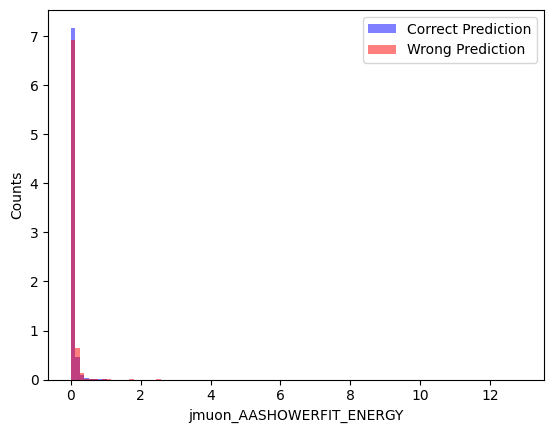

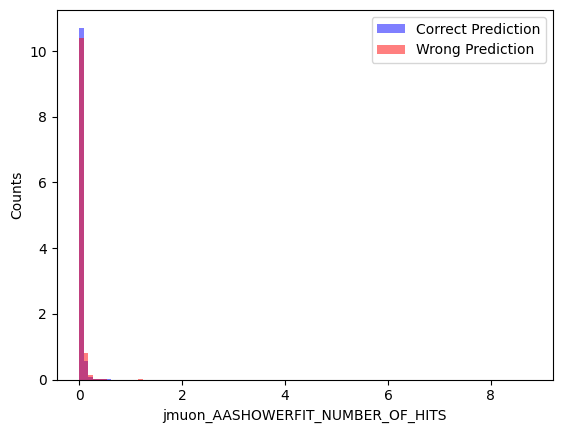

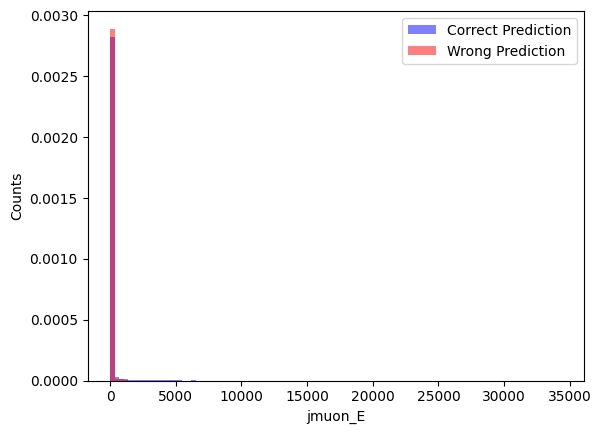

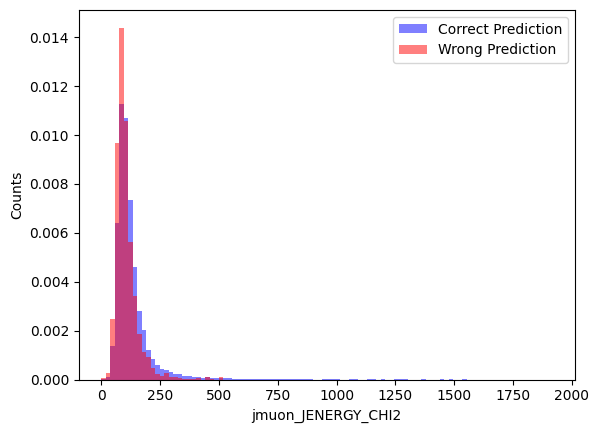

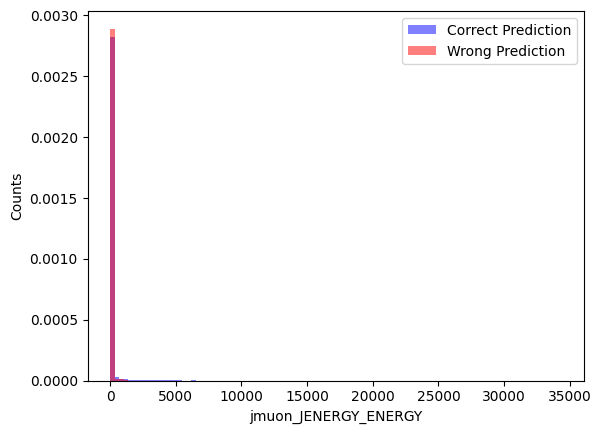

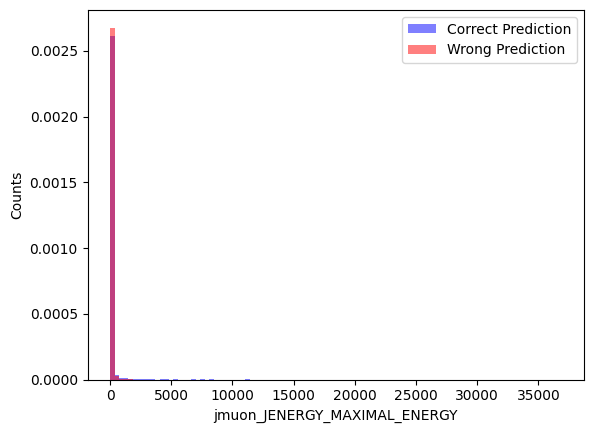

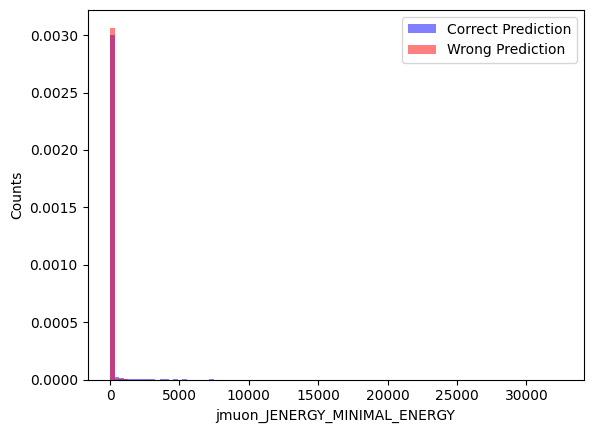

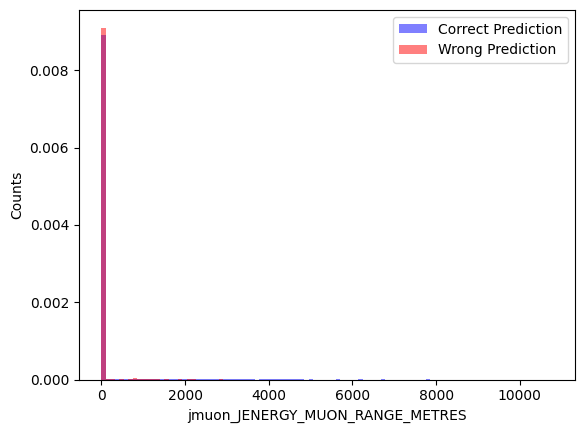

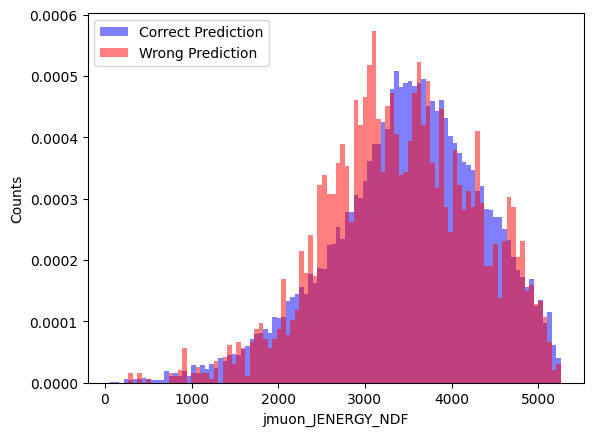

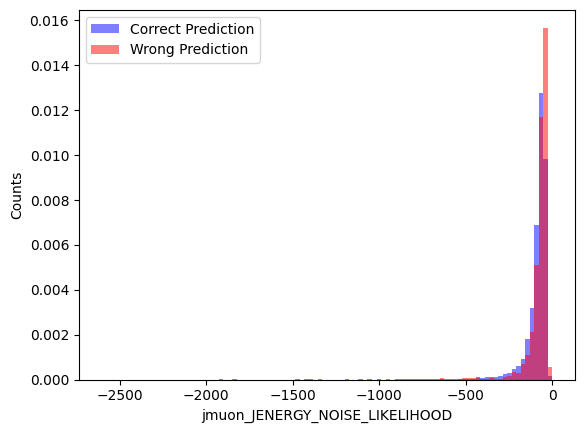

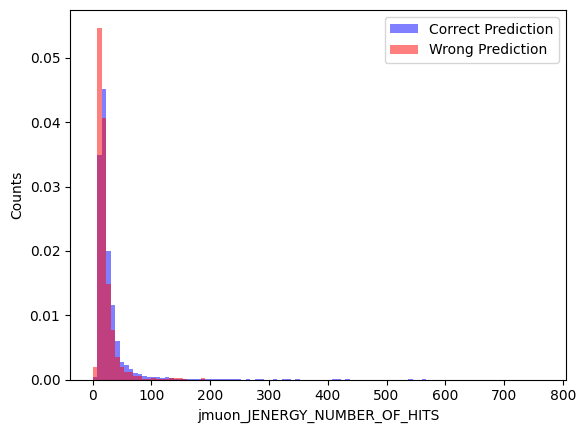

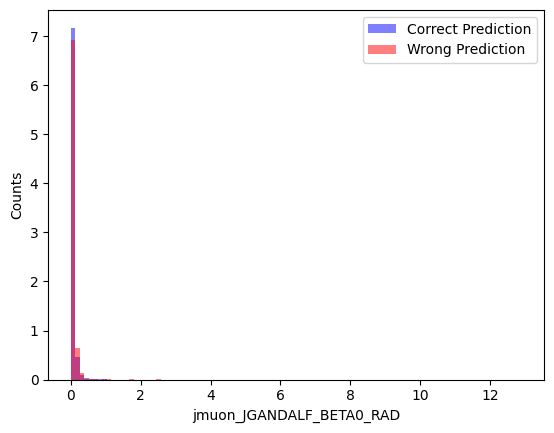

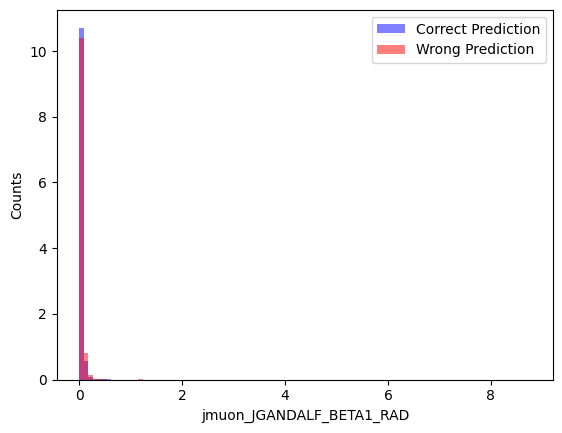

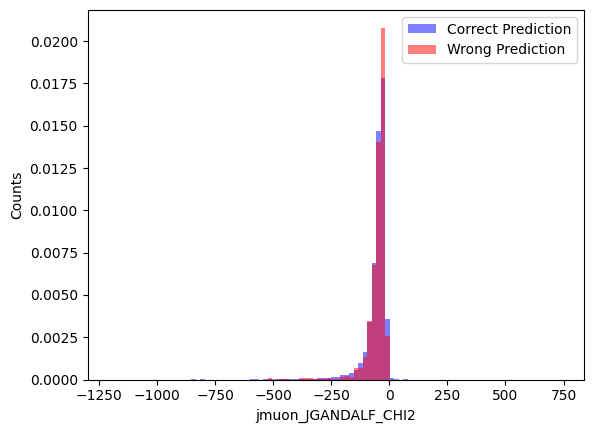

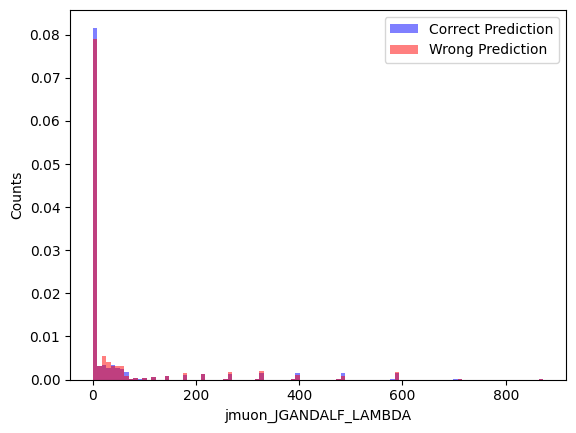

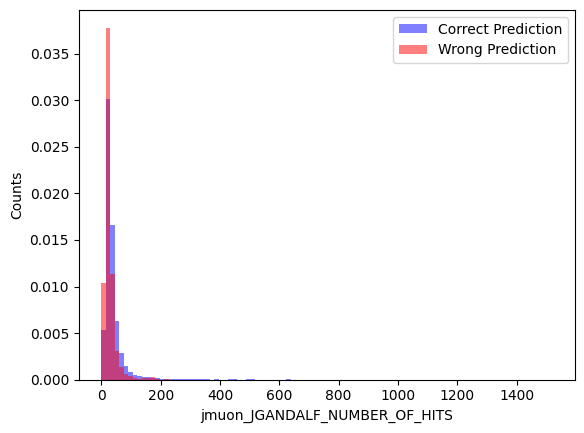

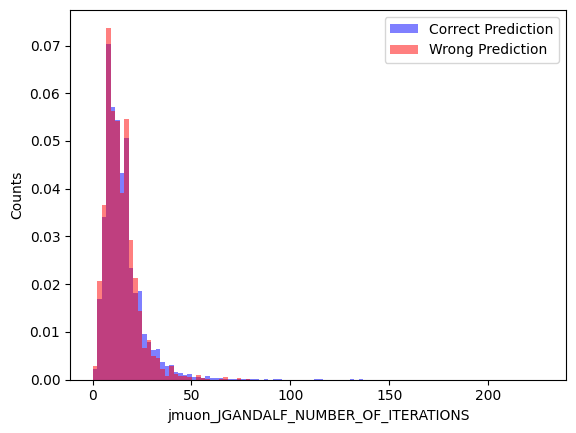

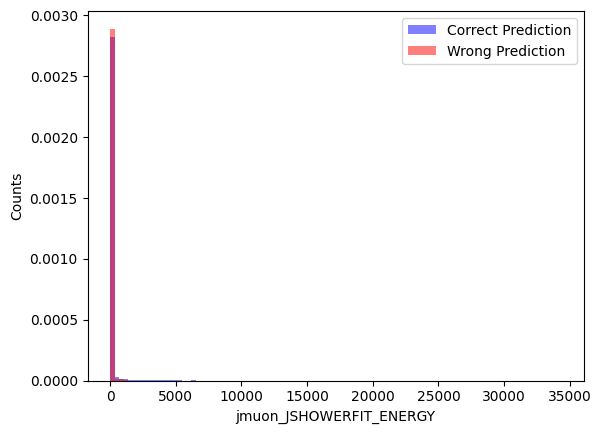

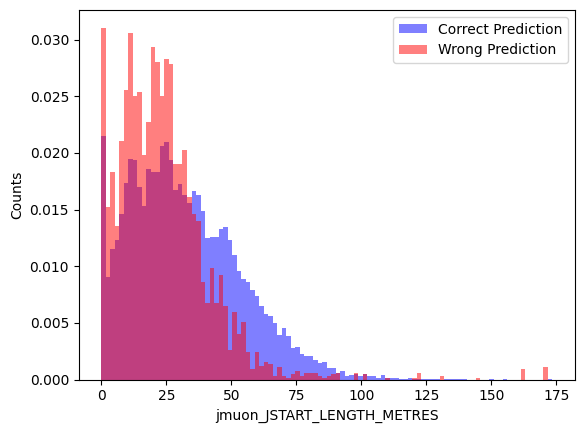

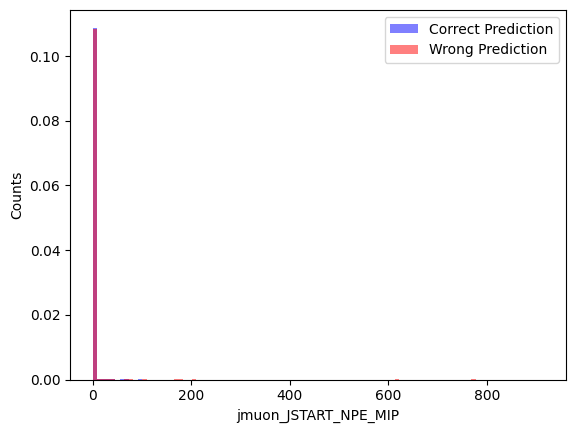

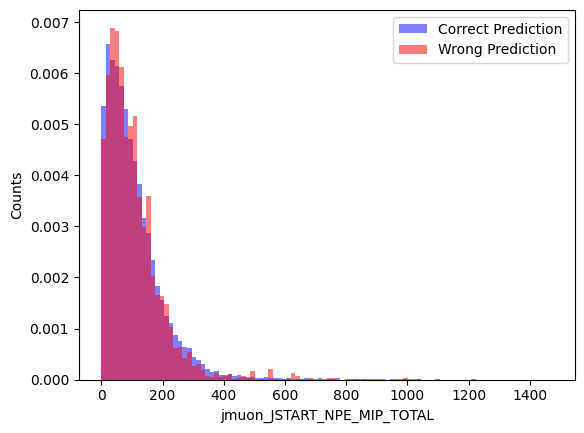

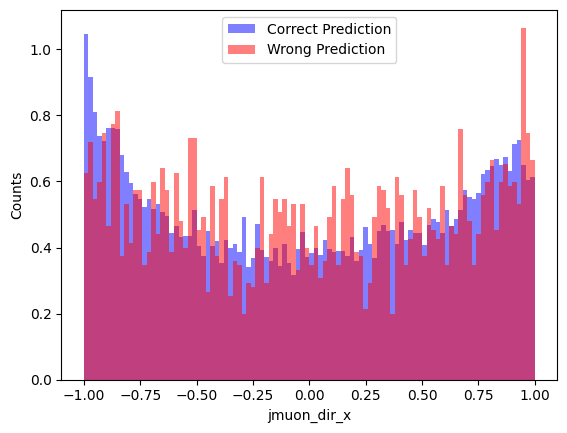

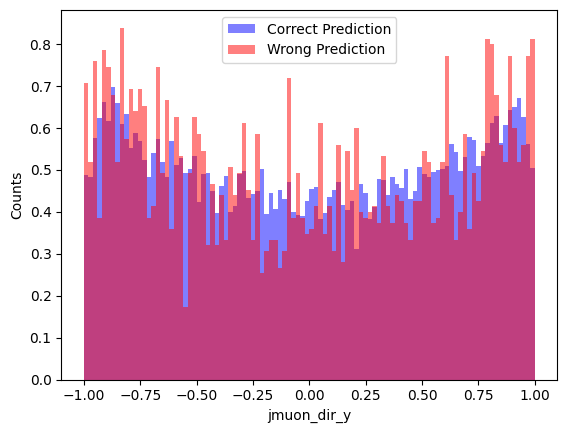

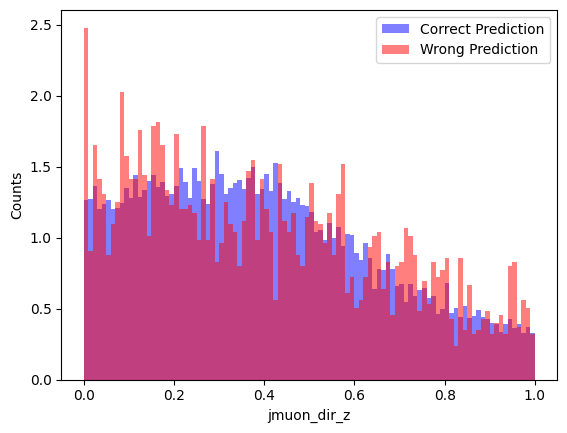

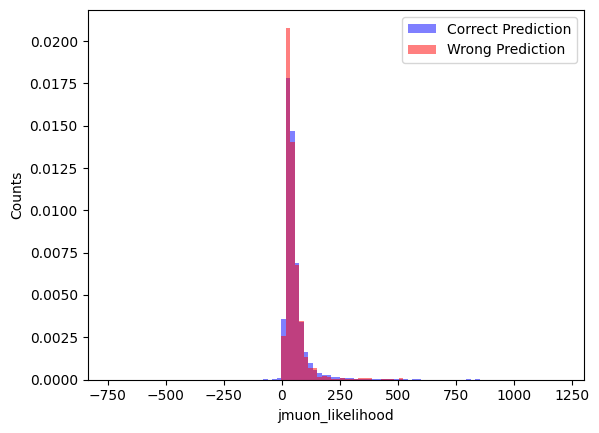

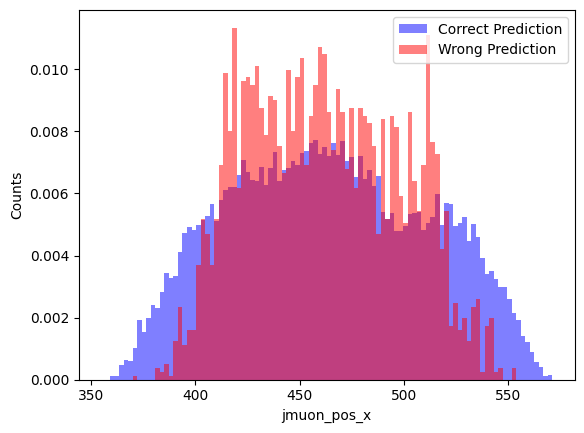

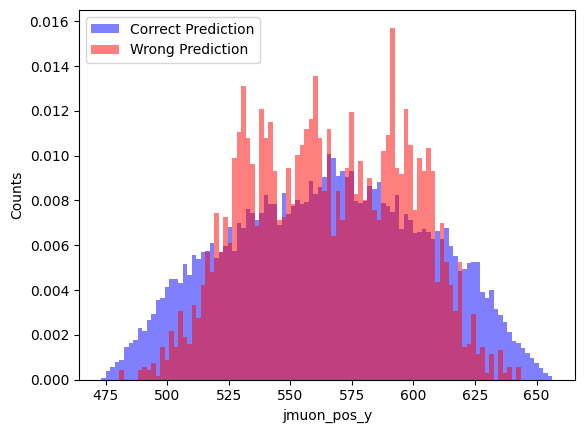

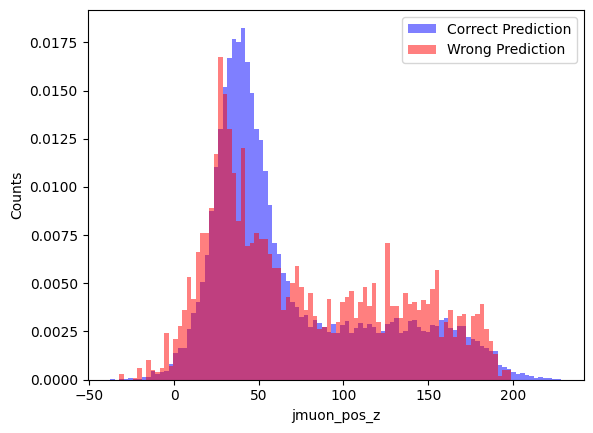

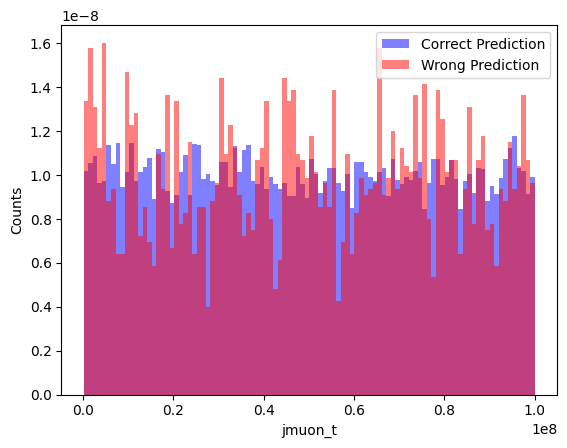

In [51]:
# test_scores, df_prediction_difficulties, hists_true, hists_false, columns, bins = experiment(paths_atm_muon, paths_atm_neutr, neutr_types, 50)
print("Mean Test Score: ", np.mean(test_scores))
print("Std Test Score: ", np.std(test_scores))

avg_prediction_difficulties = df_prediction_difficulties.mean()
std_prediction_difficulties = df_prediction_difficulties.std()
# print("The average prediction difficulty (fraction of wrong predictions) per type is:")
# print(avg_prediction_difficulties)
for column in df_prediction_difficulties.columns:
    print("The prediction difficulty for type ", column, " is", avg_prediction_difficulties[column], "+-", std_prediction_difficulties[column])

for i, column in enumerate(X.columns):
    plt.figure()
    plt.hist(bins[i][:-1], bins=bins[i], weights = hists_true[i], alpha=0.5, density= True, label='Correct Prediction', color='blue')
    plt.hist(bins[i][:-1], bins=bins[i], weights= hists_false[i], alpha=0.5, density= True, label='Wrong Prediction', color='red')
    plt.xlabel(column)
    plt.ylabel('Counts')
    plt.legend()
    plt.show()